# Восстановление золота из руды

Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Цель исследования** - построить модель машинного обучения, которая будет предсказывать коэффициент восстановления золота из золотосодержащей руды.

Исследование пройдет в 3 этапа:

1. Подготовка данных;
2. Исследовательский анализ данных;
3. Построение и обучение модели.

## Подготовка данных.

### Изучение данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
from scipy.stats import ttest_ind
import numpy as np

%matplotlib inline
sns.set(style="whitegrid")

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector

from sklearn.impute import KNNImputer

from sklearn.dummy import DummyRegressor

SEED = 17

Откроем все файлы и изучим их.

In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')

data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

Изучим информацию о датасете.

In [3]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Рассмотрим случайные 10 строк датасета.

In [4]:
data_full.sample(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
8974,2017-03-21 17:59:59,5.720223,10.942352,9.895426,44.466002,66.852314,8.975347,2.931451,12.182136,3.061739,...,24.990574,-400.892949,22.996753,-399.485916,23.726038,-450.151805,20.005316,-449.103401,25.008933,-499.343587
18385,2018-06-22 07:59:59,4.644275,8.836356,6.460284,45.735301,59.150777,7.396128,2.541535,10.982994,2.967998,...,27.018256,-499.621159,20.061240,-490.894051,17.995134,-496.510562,13.974227,-499.824320,13.981192,-511.877664
6643,2016-12-03 12:59:59,5.306986,8.978094,12.610114,45.541273,68.579262,12.746428,4.277372,10.538270,4.164837,...,18.028929,-499.972942,15.896517,-500.499787,15.086884,-497.181526,11.961574,-472.795297,21.977991,-497.606749
5892,2016-10-31 13:59:59,6.156759,9.167131,11.103272,43.406008,77.629388,10.767035,3.025490,8.321680,3.003593,...,20.014880,-501.597112,17.087244,-500.349524,17.020315,-501.557932,14.002346,-499.211622,21.976247,-500.426472
17271,2018-05-01 23:59:59,5.318046,10.363597,7.823090,44.833258,69.966319,10.494856,1.902561,6.421239,2.276119,...,29.991543,-502.153032,20.105092,-500.300225,24.978771,-500.712563,22.999339,-500.014632,24.981065,-501.302814
5973,2016-11-04 09:59:59,2.967476,10.123619,10.142285,48.532447,58.641050,8.089714,3.346015,11.468141,3.916255,...,14.983648,-501.795886,13.012243,-466.841091,17.128371,-502.077613,14.008676,-500.160814,22.000704,-502.911676
8690,2017-03-09 01:59:59,7.376755,9.004772,8.213117,43.340099,66.126034,9.192147,3.507621,7.591832,3.787581,...,24.996602,-400.980277,22.973670,-400.501382,23.367890,-449.747637,20.009619,-449.988693,25.014232,-500.228143
8774,2017-03-12 23:59:59,5.716777,10.996612,10.949623,44.458018,66.519379,9.281740,3.379501,9.431304,3.793421,...,24.990426,-400.191136,22.963371,-400.696926,21.384416,-449.369016,19.997650,-450.060686,24.987530,-498.897310
2573,2016-05-27 01:59:59,3.564303,10.874025,8.287546,45.512467,58.662447,7.187012,2.264096,12.727203,3.130563,...,10.002794,-500.954529,7.908919,-502.495846,7.961681,-500.150625,5.990852,-499.931326,18.032878,-499.992898
4471,2016-08-22 12:59:59,6.622894,10.251192,10.311627,42.855745,67.749653,10.259454,2.539717,8.378037,3.794230,...,18.021012,-401.224882,10.021642,-400.195782,10.021480,-400.935604,5.022732,-399.767636,24.966538,-499.777581


Количество дубликатов.

In [5]:
data_full.duplicated().sum()

0

Проверим размерность таблиц и то, что данные разделены верно.

In [6]:
print(f'Размерность полной таблицы {data_full.shape}')
print(f'Размерность тренировочного набора {data_train.shape}')
print(f'Размерность тестового набора {data_test.shape}')

Размерность полной таблицы (19439, 87)
Размерность тренировочного набора (14149, 87)
Размерность тестового набора (5290, 53)


In [7]:
len(data_full) == len(data_train) + len(data_test)

True

**Вывод**

1. На данном этапе были рассмотрены данные. В таблице имеется 87 столбцов, которые характеризуют различные процессы производства;
2. В данных присутствуют пропуски. Анализ пропусков проведем в предобработке данных;
3. Дубликаты в данных отсутсвуют;
4. Размерность тренировочного и тестового набора различается. В тестовом наборе меньше признаков;
5. При просмотре таблицы можно заметить, что порядок величин отличается. В дальнейшем понадобится масштабирование.

### Проверка расчётов эффективности обогащения

Вычислим `recovery` для признака `rougher.output.recovery` на обучающей выборке и найдем MAE.

In [8]:
# доля золота в концентрате после флотации/очистки
C = data_train['rougher.output.concentrate_au' ]

# доля золота в сырье/концентрате до флотации/очистки;
F = data_train['rougher.input.feed_au']

# доля золота в отвальных хвостах после флотации/очистки
T = data_train['rougher.output.tail_au']

In [9]:
recovery = ((C * (F - T)) / (F * (C - T))) * 100

In [10]:
MAE = sum(abs(recovery - data_train['rougher.output.recovery'])) / len(data_train['rougher.output.recovery'])

print(f'Абсолютная ошибка между расчитанными и представленными данными равна {MAE}')

Абсолютная ошибка между расчитанными и представленными данными равна 9.73512347450521e-15


**Вывод**

Вычисленная ошибка между расчитанными и представленными данными мала, следовательно, расчеты были выполнены верно.

### Анализ признаков, не представленных в обучающей выборке.

In [11]:
set(data_train.columns) - set(data_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

**Вывод**

1. В тестовой выборке отсутствуют выходные параметры `.output.` на каждом этапе;
2. Так же отсутствуют расчетные признаки на этапе флотации (концентрация сульфатов, соотношение золота/свинца);
3. Данные признаки не подходят для обучения модели, т.к. оцениваются после измерения целевых признаков.

### Предобработка данных.

На данном этапе проведем работу с данными, а именно:

1. Рассмотрим корреляции признаков;
2. Заполнение пропусков.

Так как количество признаков в тестовом и тренировочном наборе отличается, для изучения корреляции оставим только признаки из тестового набора и добавим таргеты. Это же признаковое пространство будет использовано для обучения модели.

In [12]:
test_feature = list(data_test.columns)

target_feature = ['final.output.recovery', 'rougher.output.recovery']

feature_corr = test_feature + target_feature

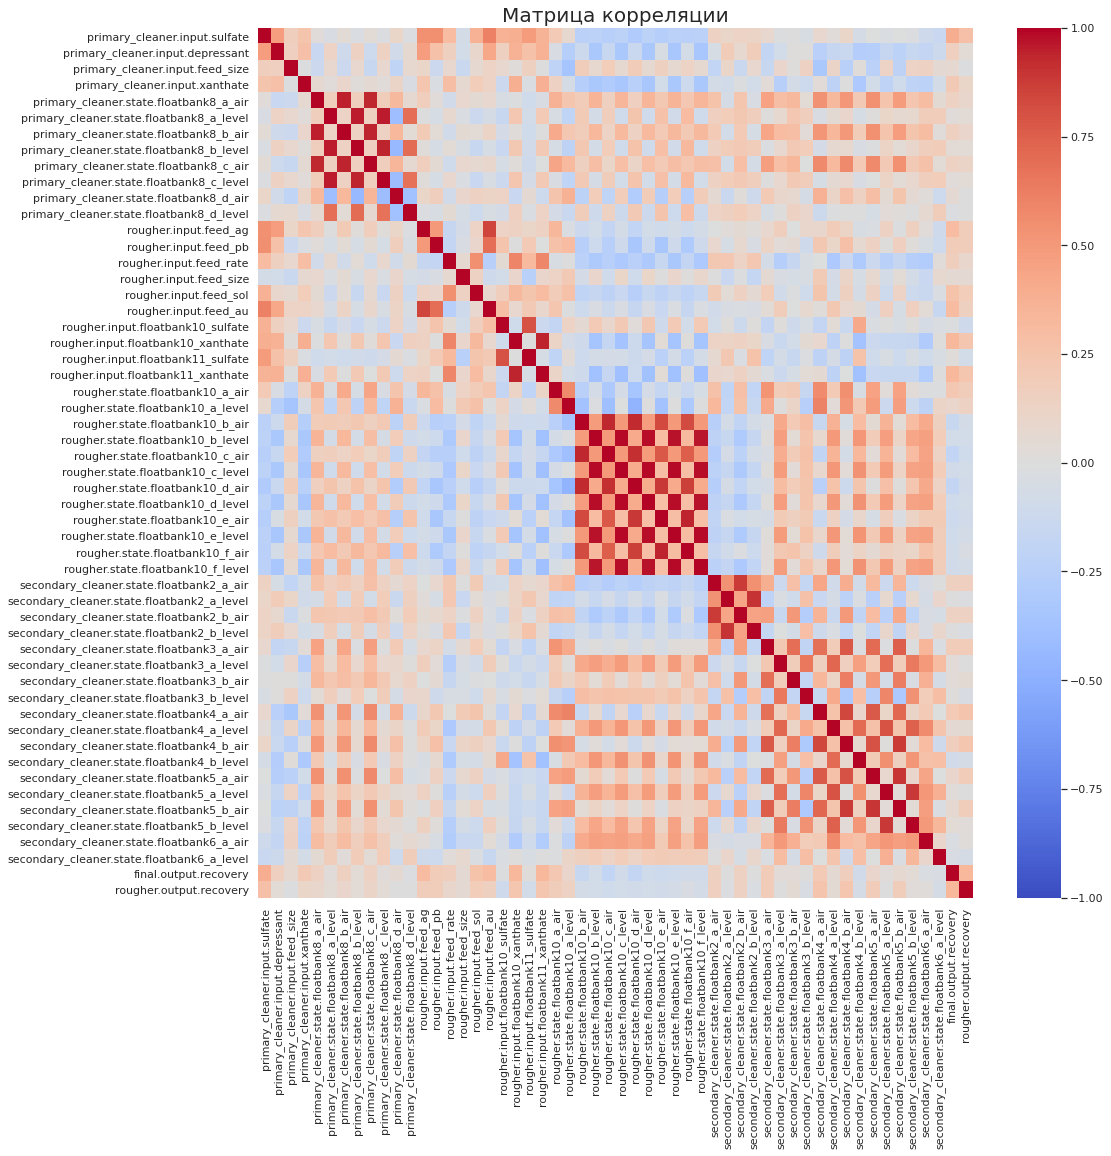

In [74]:
f, ax = plt.subplots(figsize=(16, 16))


sns.heatmap(data_train[feature_corr].corr(), annot=False, 
            vmin=-1, vmax=1, 
            center= 0, cmap= 'coolwarm')
plt.title('Матрица корреляции', fontsize=20);

На графике мы видим множество признаков, которые коррелируют между собой. В основном это признаки, которые описывают состояние технологических процессов на производстве.

Насколько имеет смысл удалять данные признаки? Я считаю, что не нужно этого делать. Единственная причина по которой это можно сделать - это ограничения по скорости работы модели и по памяти, но в данном случае у нас нет никаких ограничений, поэтому оставим в неизменном виде все признаковое пространство.

Рассмотрим пропуски в данных. Выразим их в процентах.

In [14]:
data_train[feature_corr].isna().mean() * 100

date                                          0.000000
primary_cleaner.input.sulfate                 0.141353
primary_cleaner.input.depressant              0.226164
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                0.706764
primary_cleaner.state.floatbank8_a_air        0.028271
primary_cleaner.state.floatbank8_a_level      0.007068
primary_cleaner.state.floatbank8_b_air        0.028271
primary_cleaner.state.floatbank8_b_level      0.007068
primary_cleaner.state.floatbank8_c_air        0.014135
primary_cleaner.state.floatbank8_c_level      0.007068
primary_cleaner.state.floatbank8_d_air        0.021203
primary_cleaner.state.floatbank8_d_level      0.007068
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.706764
rougher.input.feed_rate                       0.056541
rougher.input.feed_size                       1.017740
rougher.input.feed_sol                        0.551276
rougher.in

In [15]:
data_test.isna().mean() * 100

date                                          0.000000
primary_cleaner.input.sulfate                 0.075614
primary_cleaner.input.depressant              0.094518
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                0.075614
primary_cleaner.state.floatbank8_a_air        0.000000
primary_cleaner.state.floatbank8_a_level      0.000000
primary_cleaner.state.floatbank8_b_air        0.000000
primary_cleaner.state.floatbank8_b_level      0.000000
primary_cleaner.state.floatbank8_c_air        0.000000
primary_cleaner.state.floatbank8_c_level      0.000000
primary_cleaner.state.floatbank8_d_air        0.000000
primary_cleaner.state.floatbank8_d_level      0.000000
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.000000
rougher.input.feed_rate                       0.056711
rougher.input.feed_size                       0.018904
rougher.input.feed_sol                        0.396975
rougher.in

**Вывод**

1. Значительное (свыше 3%) количество признаков в тренировочном наборе присутсвует в столбцах `rougher.state.floatbank10_e_air` и `rougher.input.floatbank11_xanthate`. Посмотрим на причину появления пропусков в этих признаках - были ли это случайные пропуски или же существовали периоды, в которые данные не вносились;
2. В тестовом наборе также присутствуют пропуски. Заполнять их здесь не имеет смысла, поэтому их мы удалим из датасета.

Создадим флаг, который указывает, что в данном месте был пропуск.

In [16]:
data_temp = data_train[feature_corr].copy()

In [17]:
data_temp['floatbank10_e_air_is_na'] = data_temp['rougher.state.floatbank10_e_air'].\
                                       apply(lambda val: 1 if np.isnan(val) else 0)

data_temp['floatbank11_xanthate_is_na'] = data_temp['rougher.input.floatbank11_xanthate'].\
                                          apply(lambda val: 1 if np.isnan(val) else 0)

In [18]:
data_temp['date'] = pd.to_datetime(data_temp['date'])

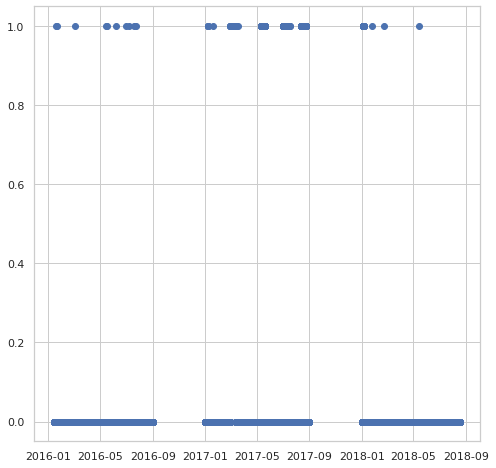

In [19]:
f, ax = plt.subplots(figsize=(8, 8))


plt.plot_date(x=data_temp['date'], y=data_temp['floatbank11_xanthate_is_na']);

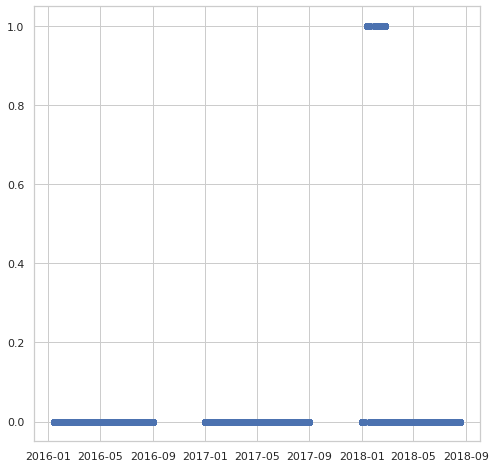

In [20]:
f, ax = plt.subplots(figsize=(8, 8))


plt.plot_date(x=data_temp['date'], y=data_temp['floatbank10_e_air_is_na']);

**Вывод**

По результатам анализа выяснилось, что пропуски в стобце `rougher.state.floatbank10_e_air` имели систематический характер на протяжении определенного периода. Возможно, что в тот момент измеряющее оборудование было в ремонте/на модернизации. Так же стоит отметить, что у нас существуют данные на начало периода, когда начинаются пропуски.

Характер пропусков в столбце `rougher.input.floatbank11_xanthate` имеет более случайный характер. Это в основном периодические и не продолжительные пропуски.

В остальных столбцах количество пропусков не так велико (<= 1%). Выберем две стратегии борьбы с пропусками:
1. Заполнение пропуска предыдущим известным значением;
2. С использованием KNNImputer.

Первая стратегия заключается в том, что соседние по времени значения часто похожи, а следовательно, их можно заменить этим значением без ущерба.

Вторая стратегия заключается в том, что в признаковом пространстве пропуски будут близко находится к известным значениям, которыми мы и заменим пропуски.

Пропуски заменим непосредственно перед обучением.

In [21]:
del data_temp

## Анализ данных

### Изменение концентрации металлов на различных этапах отчистки.

В данных присутствует 3 различных металла:
* `Au` - золото;
* `Pb` - свинец;
* `Ag` - серебро.

Изменения концетрации металлов отследим с помощью двух графиков:
1. Графики по времени;
2. Гистограмы.

In [22]:
data_temp = data_full.copy()

Будем использовать дату как индексы.

In [23]:
data_temp = data_temp.set_index(pd.DatetimeIndex(data_temp['date'])).drop(columns=['date'])

Напишем функцию, которая будет отображать необходимую информацию.

In [24]:
def plot_concentrate(data: pd.DataFrame, metal: str):
    
    '''
    Функция отображает 2 графика:
    1. График изменения концентрации от времени;
    2. Гистограму частот.
    
    Output: None
    Input: data: pd.DataFrame - входные данные;
           metal: str - интересующий метал.
    '''
    
    rougher = 'rougher.output.concentrate_' + metal
    cleaner = 'primary_cleaner.output.concentrate_' + metal
    final = 'final.output.concentrate_' + metal
    
    columns_plot = [rougher, cleaner, final]
    
    f, ax = plt.subplots(2, 1, figsize=(16, 16))
    
    sns.lineplot(data=data[columns_plot].groupby(data.index.floor('D')).mean(), ax=ax[0])
    ax[0].set_title(f'Зависимость концентрации от времени для {metal}')
    ax[0].set_xlabel('Дата')
    ax[0].set_ylabel('Концентрация (%)')
    
    sns.histplot(data=data[columns_plot])
    ax[1].set_title(f'Гистограма частот для {metal}')
    ax[1].set_xlabel('Концентрация (%)')

Построим графики для золота.

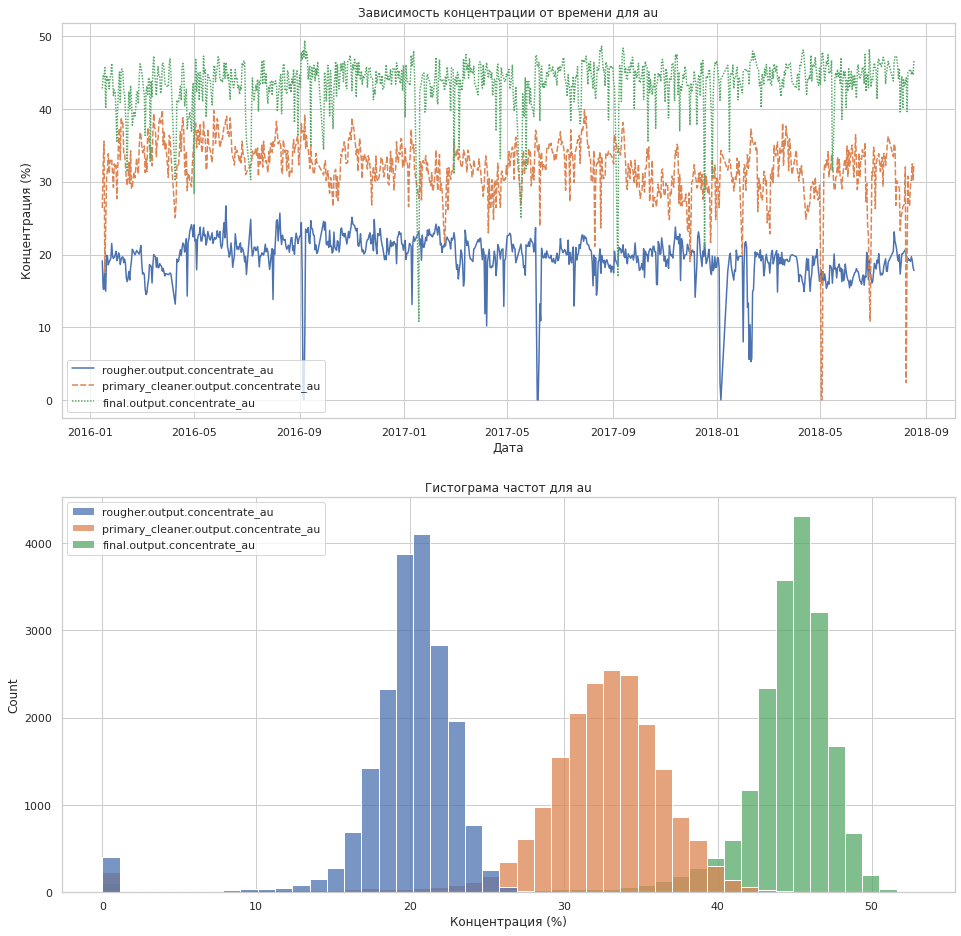

In [25]:
plot_concentrate(data_temp, 'au')

Построим графики для серебра.

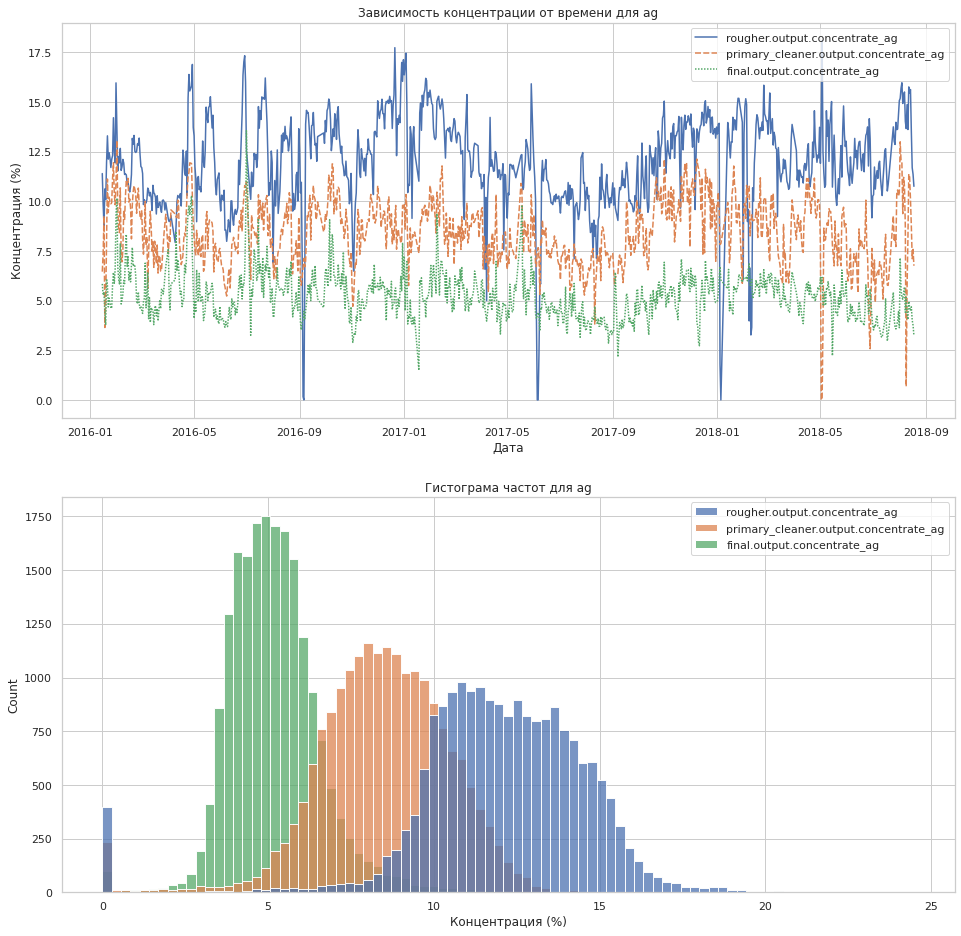

In [26]:
plot_concentrate(data_temp, 'ag')

Построим графики для свинца.

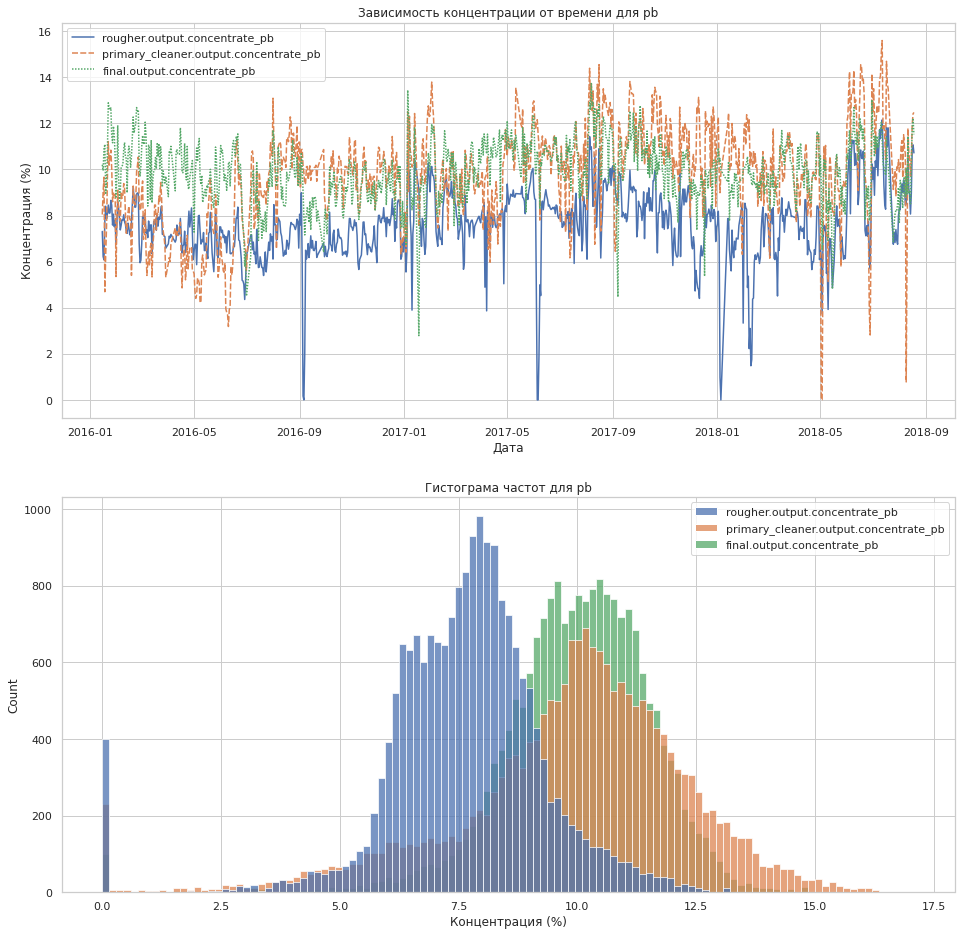

In [27]:
plot_concentrate(data_temp, 'pb')

**Вывод**

1. С каждым этапом очистки концентрация золота растет;
2. С каждым этапом очистки концентрация серебра падает;
3. С каждым этапом очистки концентрация свинца незначительно увеличивается;
4. Графики зависимости концентрации от времени изменяются незначительно, что говорит о стабильности и налаженности тех.процессов на производстве.

### Сравнение распределения гранул сырья

Сравним распределения размеров гранул сырья для двух выборок. Если распределения будут сильно отличатся, то оценка модели будет неправильной.

Значения для распределений возьмем из двух признаков:

* `primary_cleaner.input.feed_size`
* `rougher.input.feed_size`

Производить сравнение будем как визуально, так и с помощью критерия t-стьюдента.

#### rougher.input.feed_size

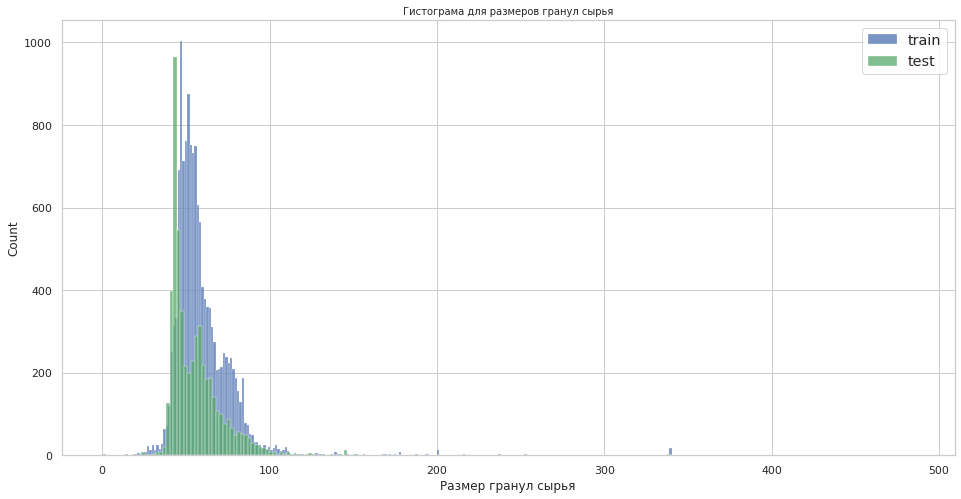

In [28]:
f, ax = plt.subplots(figsize=(16,8))

sns.histplot(x='rougher.input.feed_size', data=data_train);

sns.histplot(x='rougher.input.feed_size', data=data_test, color='g');

ax.legend(['train', 'test'], fontsize='large');
ax.set_title('Гистограма для размеров гранул сырья', fontsize=10)
ax.set_xlabel('Размер гранул сырья');

Визуально выборки отличаются друг от друга, но не очевидно насколько сильно это отличие. Так же видим, что присутствует значительное число выбросов, которые могут повлиять на результаты тестов.

Проведем независимый t-test.
* `H_0:` размер гранул сырья на обучающей и тестовой выборке не отличаются;
* `H_1:` размер гранул сырья на обучающей и тестовой выборке отличаются.

Критерий уровня значимости выберем `alpha=0.05` (вероятность совершить ошибку первого рода)

In [29]:
ALPHA = 0.05

In [30]:
train_size = data_train['rougher.input.feed_size']
test_size = data_test['rougher.input.feed_size']

Посмотрим на размер выборок.

In [31]:
print(len(train_size), len(test_size))

14149 5290


Так как размеры выборок не равны, используем флаг `equal_var=False` в t-тесте

In [32]:
t_test = ttest_ind(
    train_size,
    test_size,
    nan_policy='omit',
    equal_var=False
)

if t_test.pvalue >= ALPHA:
    print(f'Отклоняем альтернативную гипотезу, уровень значимости равен {t_test.pvalue}')
else:
    print(f'Принимаем альтернативную гипотезу, уровень значимости равен {t_test.pvalue}')

Принимаем альтернативную гипотезу, уровень значимости равен 1.5360283753498916e-37


Таким образом, нельзя подтвердить, что распределения гранул сырья двух выборок получены из одной ГС. Попробуем убрать выбросы из распределений и повторить t_test еще раз.

Вычислим 25й и 75й квартили распределений и межквартильный размах.

In [33]:
q1_train, q3_train = np.nanpercentile(train_size, [25, 75])
q1_test, q3_test = np.nanpercentile(test_size, [25, 75])


IQR_train = q3_train - q1_train
IQR_test = q3_test - q1_test

lower_bound_train, upper_bound_train = q1_train - 3 * IQR_train, q3_train + 3 * IQR_train
lower_bound_test, upper_bound_test = q1_test - 3 * IQR_test, q3_test + 3 * IQR_test

Удалим выбросы из выборок.

In [34]:
train_size_wo = train_size[(train_size >= lower_bound_train) & (train_size <= upper_bound_train)]
test_size_wo = test_size[(test_size >= lower_bound_test) & (test_size <= upper_bound_test)]

In [35]:
t_test = ttest_ind(
    train_size_wo,
    test_size_wo,
    nan_policy='omit',
    equal_var=False
)

if t_test.pvalue >= ALPHA:
    print(f'Отклоняем альтернативную гипотезу, уровень значимости равен {t_test.pvalue}')
else:
    print(f'Принимаем альтернативную гипотезу, уровень значимости равен {t_test.pvalue}')

Принимаем альтернативную гипотезу, уровень значимости равен 1.138064190138984e-56


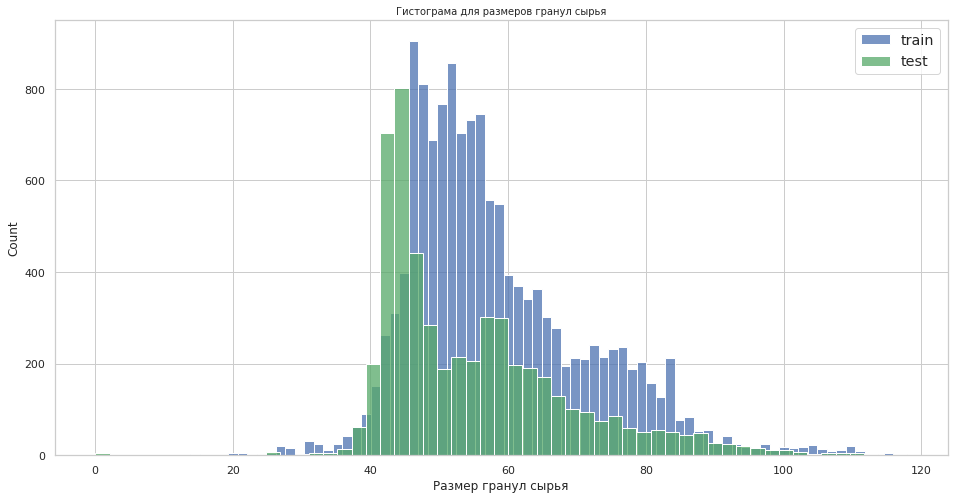

In [36]:
f, ax = plt.subplots(figsize=(16,8))

sns.histplot(data=train_size_wo);

sns.histplot(data=test_size_wo, color='g');

ax.legend(['train', 'test'], fontsize='large');
ax.set_title('Гистограма для размеров гранул сырья', fontsize=10)
ax.set_xlabel('Размер гранул сырья');

**Вывод**

В модели данный признак использовать нельзя, т.к. он даст неправильную оценку.

In [37]:
del test_size, train_size, test_size_wo, train_size_wo

#### primary_cleaner.input.feed_size

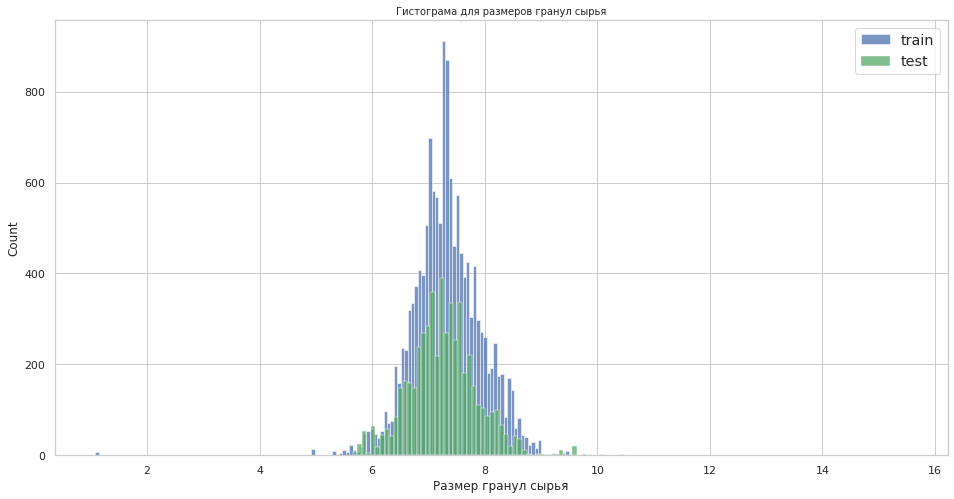

In [38]:
f, ax = plt.subplots(figsize=(16,8))

sns.histplot(x='primary_cleaner.input.feed_size', data=data_train);

sns.histplot(x='primary_cleaner.input.feed_size', data=data_test, color='g');

ax.legend(['train', 'test'], fontsize='large')
ax.set_title('Гистограма для размеров гранул сырья', fontsize=10)
ax.set_xlabel('Размер гранул сырья');

In [39]:
train_size = data_train['primary_cleaner.input.feed_size']
test_size = data_test['primary_cleaner.input.feed_size']

In [40]:
t_test = ttest_ind(
    train_size,
    test_size,
    nan_policy='omit'
)

if t_test.pvalue >= ALPHA:
    print(f'Отклоняем альтернативную гипотезу, уровень значимости равен {t_test.pvalue}')
else:
    print(f'Принимаем альтернативную гипотезу, уровень значимости равен {t_test.pvalue}')

Принимаем альтернативную гипотезу, уровень значимости равен 1.4864182925957636e-08


**Вывод**

При кажущейся близости распределений t-тест говорит о том, что эти распределения получены из разных ГС. Следовательно, ни один из этих признаков лучше не использовать в конечной модели.

In [41]:
del test_size, train_size

### Исследование суммарных концентраций веществ

Помимо металлов в смеси находятся и другие вещества, исследуем концентрацию добавив `sol (золь)` в анализ.

Расчитаем суммарные концентрации на 3х этапах:
* в сырье;
* в черновом концентрате;
* в финальном концентрате.

In [42]:
data_temp['feed_conc'] = data_temp['rougher.input.feed_ag'] + data_temp['rougher.input.feed_pb'] +\
                         data_temp['rougher.input.feed_au'] + data_temp['rougher.input.feed_sol']

data_temp['rougher_conc'] = data_temp['rougher.output.concentrate_ag'] + data_temp['rougher.output.concentrate_pb'] +\
                            data_temp['rougher.output.concentrate_sol'] + data_temp['rougher.output.concentrate_au']

data_temp['finac_conc'] = data_temp['final.output.concentrate_ag'] + data_temp['final.output.concentrate_pb'] +\
                          data_temp['final.output.concentrate_sol'] + data_temp['final.output.concentrate_au']

In [43]:
column_to_show = ['feed_conc', 'rougher_conc', 'finac_conc']

Отобразим полученные графики.

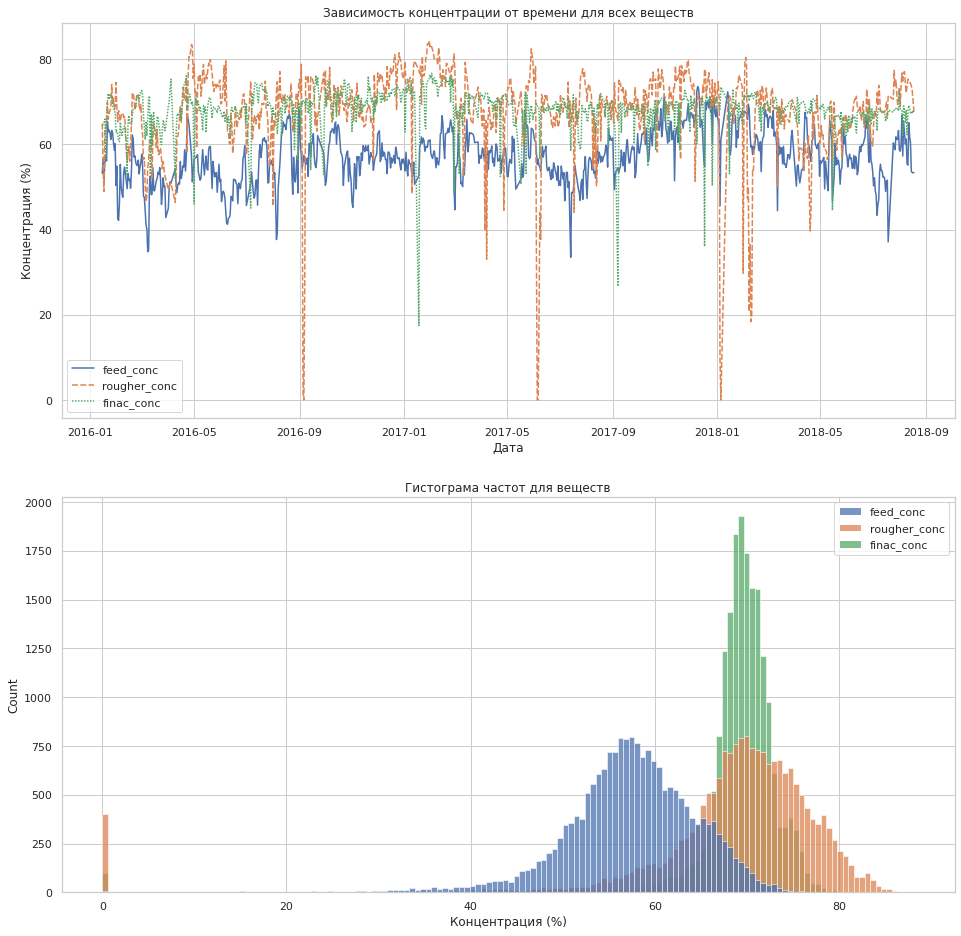

In [44]:
f, ax = plt.subplots(2, 1, figsize=(16, 16))
    
sns.lineplot(data=data_temp[column_to_show].groupby(data_temp.index.floor('D')).mean(), ax=ax[0])
ax[0].set_title('Зависимость концентрации от времени для всех веществ')
ax[0].set_xlabel('Дата')
ax[0].set_ylabel('Концентрация (%)')
    
sns.histplot(data=data_temp[column_to_show], ax=ax[1])
ax[1].set_title(f'Гистограма частот для веществ')
ax[1].set_xlabel('Концентрация (%)');

**Вывод**

1. В данных присутствуют аномалии - суммарные концентрации падают до 0. Это значит, что в такие дни измерения не производились. Такие данные не несут информации, удалим их из данных.
2. Стандартное отклонение для финальной стадии меньше, чем после флотации. Это говорит о том, что последующая вторичная фильтрация не дает дополнительной отчистки, но стабилизирует результат.

Удалим аномальные значения из тренировочных данных.

In [45]:
data_train['feed_conc'] = data_train['rougher.input.feed_ag'] + data_train['rougher.input.feed_pb'] +\
                          data_train['rougher.input.feed_au'] + data_train['rougher.input.feed_sol']

data_train['rougher_conc'] = data_train['rougher.output.concentrate_ag'] + data_train['rougher.output.concentrate_pb'] +\
                             data_train['rougher.output.concentrate_sol'] + data_train['rougher.output.concentrate_au']

data_train['finac_conc'] = data_train['final.output.concentrate_ag'] + data_train['final.output.concentrate_pb'] +\
                           data_train['final.output.concentrate_sol'] + data_train['final.output.concentrate_au']

In [46]:
data_train_wo = data_train.loc[(data_train['feed_conc'] > 25) &
                               (data_train['rougher_conc'] > 25) &
                               (data_train['finac_conc'] > 25)]

In [47]:
data_train_wo = data_train_wo.reset_index(drop=True)

In [48]:
len(data_train) - len(data_train_wo)

814

Удалено 814 объектов.

In [49]:
del data_temp

## Построение модели

### Напишите функцию для вычисления итоговой sMAPE

Перед непосредственным построением модели введем новую метрику качества - `sMAPE`. Напишем функцию, которая будет вычислять данный показатель.

In [50]:
def smape(target: np.array, prediction: np.array) -> float:
    
    '''
    Функция расчитывает показатель sMAPE - Symmetric Mean Absolute Percentage Error, 
    симметричное среднее абсолютное процентное отклонение.
    
    Input: target: np.array - целевые значения признака;
           predictions: np.array - предсказанные значения признака;
    Output: smape: float - показатель sMAPE (%)
    '''
    
    numerator = abs(prediction - target)
    denominator = (abs(target) + abs(prediction)) / 2
    _sum = (numerator / denominator).sum()

    smape = 1 / len(target) * _sum * 100
    
    return smape

In [51]:
def total_smape(rougher_smape: float, final_smape: float) -> float:
    
    '''
    Функция расчитывает итоговый показатель sMAPE,
    расчитанный для стадий rougher и final
    
    Input: rougher_smape: float - показатель sMAPE, рассчитаный для стадии rougher;
           final_smape: float - показатель sMAPE, рассчитаный для стадии final.
    Output: final_smape: float - финальный показатель sMAPE.
    '''
    
    final_smape = 0.25 * rougher_smape + 0.75 * final_smape
    
    return final_smape

### Обучение и оценка качества моделей.

Для прогнозирования будем использовать семейство линейных моделей:
* `LinearRegression`;
* `Lasso`;
* `ElasticNet`;
* `Ridge`.

Добавим целевой признак для `data_test` из `data_full`

In [52]:
data_test = data_test.merge(data_full[['date', 'rougher.output.recovery', 'final.output.recovery']], 
                            how = 'left', on = 'date')

Так же стоит отметить, что признаковые пространства для признака `rougher.output.recovery` и `final.output.recovery` возможно будут различатся. Это основано на предположении, что тех.процесс после стадии флотации опирается на его результаты.

In [53]:
rougher_features = []

for column in data_test.columns:
    if column.startswith('rougher'):
        rougher_features.append(column)
        
rougher_features

['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'rougher.output.recovery']

Признаки, необходимые для обучения находятся в переменной `feature_corr`

In [54]:
data_model_train = data_train_wo[feature_corr]
data_model_test = data_test[feature_corr]

Создадим тренировочные и тестовые наборы для стадий `rougher` и `final`. Из тестовых наборов удалим пропуски.

In [55]:
data_model_train_rougher = data_model_train[rougher_features]
data_model_test_rougher = data_model_test[rougher_features].dropna()

In [56]:
data_model_train_final = data_model_train.copy()
data_model_test_final = data_model_test.copy().dropna()

Выделим целевой признак. Так же из наборов уберем признаки `rougher.input.feed_size` и `primary_cleaner.input.feed_size`, которые могут негативно влиять на модель.

In [57]:
X_train_rougher = data_model_train_rougher.drop(columns=['rougher.input.feed_size', 'rougher.output.recovery'])
y_train_rougher = data_model_train_rougher['rougher.output.recovery']

X_test_rougher = data_model_test_rougher.drop(columns=['rougher.input.feed_size', 'rougher.output.recovery'])
y_test_rougher = data_model_test_rougher['rougher.output.recovery']

In [58]:
X_train_final = data_model_train_final.drop(columns=['date', 'rougher.input.feed_size', 'final.output.recovery', 
                                                     'rougher.output.recovery', 'primary_cleaner.input.feed_size'])
y_train_final = data_model_train_final['final.output.recovery']


X_test_final = data_model_test_final.drop(columns=['date', 'rougher.input.feed_size', 'final.output.recovery', 
                                                   'rougher.output.recovery', 'primary_cleaner.input.feed_size'])
y_test_final = data_model_test_final['final.output.recovery']

Как ранее отмечалось, в данных присутсвуют пропуски. Используем 2 метода для заполнения пропусков:
1. метод `ffill`, который заполняет пропуск предыдущим известным значением;
2. KNNImputer.

Обучим модели, используя оба метода заполнения пропусков и посмотрим какой метод дает лучший результат.

#### method='ffill'

Заполним пропуски.

In [59]:
X_train_rougher_ffill = X_train_rougher.fillna(method='ffill')
X_train_final_ffill = X_train_final.fillna(method='ffill')

Напишем пайплайн для обучения модели.

In [60]:
num_pipe_ffill = make_pipeline(
    StandardScaler()
)

preprocessor = make_column_transformer(
    (num_pipe_ffill, selector(dtype_include="number"))
)

Создадим объекты моделей.

In [61]:
lr_reg = make_pipeline(preprocessor, LinearRegression())
lasso = make_pipeline(preprocessor, Lasso(random_state=SEED))
elastic = make_pipeline(preprocessor, ElasticNet(random_state=SEED))
ridge = make_pipeline(preprocessor, Ridge(random_state=SEED))

In [62]:
models = [lr_reg, lasso, elastic, ridge]
cv=5

Для оценки моделей будем использовать кросс-валидацию

In [63]:
results_cross_val = []

for model in models:
    
    scorer = make_scorer(smape) 
    
    cross_val_score_rougher = cross_val_score(model, 
                                              X_train_rougher_ffill, 
                                              y_train_rougher, 
                                              cv=cv, scoring=scorer).mean()
    cross_val_score_final = cross_val_score(model, 
                                            X_train_final_ffill, 
                                            y_train_final, 
                                            cv=cv, scoring=scorer).mean()

    results_cross_val.append({'model name': model[1].__class__.__name__, 
                              'cross_val_score_rougher': cross_val_score_rougher, 
                              'cross_val_score_final': cross_val_score_final,
                              'cross_val_sMAPE': total_smape(cross_val_score_rougher, cross_val_score_final)})

              
pd.DataFrame(results_cross_val)

,model name,cross_val_score_rougher,cross_val_score_final,cross_val_sMAPE
0,LinearRegression,6.629672,10.052116,9.196505
1,Lasso,6.635883,8.793889,8.254387
2,ElasticNet,6.235556,8.604475,8.012245
3,Ridge,6.626548,10.046010,9.191144


#### KNNImputer

Проделаем аналогичные шаги.

In [64]:
knn_imputer = KNNImputer()

num_pipe_knn = make_pipeline(
    KNNImputer(),
    StandardScaler()
)

preprocessor_knn = make_column_transformer(
    (num_pipe_knn, selector(dtype_include="number"))
)

In [65]:
lr_reg_knn = make_pipeline(preprocessor_knn, LinearRegression())
lasso_knn = make_pipeline(preprocessor_knn, Lasso(random_state=SEED))
elastic_knn = make_pipeline(preprocessor_knn, ElasticNet(random_state=SEED))
ridge_knn = make_pipeline(preprocessor_knn, Ridge(random_state=SEED))

In [66]:
models_knn = [lr_reg_knn, lasso_knn, elastic_knn, ridge_knn]

In [67]:
results_cross_val = []

for model in models_knn:
    
    scorer = make_scorer(smape) 
    
    cross_val_score_rougher = cross_val_score(model, 
                                              X_train_rougher, 
                                              y_train_rougher, 
                                              cv=cv, scoring=scorer).mean()
    cross_val_score_final = cross_val_score(model, 
                                            X_train_final, 
                                            y_train_final, 
                                            cv=cv, scoring=scorer).mean()

    results_cross_val.append({'model name': model[1].__class__.__name__, 
                              'cross_val_score_rougher': cross_val_score_rougher, 
                              'cross_val_score_final': cross_val_score_final,
                              'cross_val_sMAPE': total_smape(cross_val_score_rougher, cross_val_score_final)})

              
pd.DataFrame(results_cross_val)

,model name,cross_val_score_rougher,cross_val_score_final,cross_val_sMAPE
0,LinearRegression,6.415354,10.016425,9.116157
1,Lasso,6.642635,8.796597,8.258107
2,ElasticNet,6.262164,8.639679,8.045301
3,Ridge,6.413950,10.010428,9.111309


**Вывод**

Оба варианта заполнения пропусков дали сопоставимые результаты. Разница в лучшей модели составила 0.03%. Интересно было бы проанализировать какое количество прибыли приносит такая разница.

По результатам кросс-валидации для дальнейшего прогноза на тестовой выборке выберем модель `ElasticNet`.

In [68]:
final_model = elastic

final_model.fit(X_train_rougher_ffill, y_train_rougher)
predict_rougher = final_model.predict(X_test_rougher)

final_model.fit(X_train_final_ffill, y_train_final)
predict_final = final_model.predict(X_test_final)

Посчитаем `sMAPE` для тестовоой выборке.

In [69]:
smape_rougher = smape(y_test_rougher, predict_rougher)
smape_final = smape(y_test_final, predict_final)

In [70]:
final_smape = total_smape(smape_rougher, smape_final)

print(f'Показатель sMAPE для тестовой выборки модели ElasticNet равен {final_smape}')

Показатель sMAPE для тестовой выборки модели ElasticNet равен 8.023407466302515


Проверим модель на адекватность. Сравним с константной моделью, которая будет предсказывать среднее значение для всех наблюдений.

In [71]:
dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(X_train_rougher_ffill, y_train_rougher)
predict_rougher_dummy = dummy_regr.predict(X_test_rougher)

dummy_regr.fit(X_train_final_ffill, y_train_final)
predict_final_dummy = dummy_regr.predict(X_test_final)

In [72]:
smape_rougher_dummy = smape(y_test_rougher, predict_rougher_dummy)
smape_final_dummy = smape(y_test_final, predict_final_dummy)

In [73]:
final_smape = total_smape(smape_rougher_dummy, smape_final_dummy)

print(f'Показатель sMAPE для тестовой выборки константной модели равен {final_smape}')

Показатель sMAPE для тестовой выборки константной модели равен 9.220513613001879


## Вывод

В данном проекте была задача построить модель машинного обучения, которая будет предсказывать коэффициент восстановления золота из золотосодержащей руды. Для решения данной задачи использовалось семейство линейных моделей.

Для выбора лучшей модели использовалась метрика `sMAPE`, которая одинаково учитывает масштаб и целевого признака, и предсказания.

Из всех моделей лучшей оказалась `ElasticNet`, которая на тестовой выборке показала результат **8.02%**, который на **1.2%** превзошел показатель констанстной модели (**9.2%**).

В ходе осмотра данных выяснилось, что признаковое пространство для тренировочного и тестового набора отличается.

Так же был выполнен анализ предоставленных данных, а именно:
1. Анализ концентрации металлов на различных стадиях;
2. Сравнение распределений гранул сырья;
3. Исследование суммарных концентраций веществ.

По итогам анализа можно сказать следующее:
1. С каждым этапом очистки концентрация золота растет;
2. С каждым этапом очистки концентрация серебра падает;
3. С каждым этапом очистки концентрация свинца незначительно увеличивается;
4. Графики зависимости концентрации от времени изменяются незначительно, что говорит о стабильности и налаженности тех.процессов на производстве.
5. Отказ от признаков `primary_cleaner.input.feed_size` и `rougher.input.feed_size`, т.к. по результатам t-теста нельзя сказать, что выборки из тренировочного и тестового набора принадлежат одной ГС.
6. Выявлены и удалены аномалии в данных, связанные с пропущенными замерами в некоторые дни.

В данных присутствовали пропуски, было предложено 2 метода заполения пропусков:
1. Заполнение пропуска предыдущим известным значением;
2. С использованием KNNImputer.

Два метода показали схожий результат, разница на кросс-валидации для лучшей модели составила **0.03%**. Интересно было бы изучить влияние на конечную прибыль такого расхождения.